In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pymc as pm

In [2]:
df = pl.read_csv("gambia.csv")
df

x,y,pos,age,netuse,treated,green,phc
f64,i64,i64,i64,i64,i64,f64,i64
349631.3,1458055,1,1783,0,0,40.85,1
349631.3,1458055,0,404,1,0,40.85,1
349631.3,1458055,0,452,1,0,40.85,1
349631.3,1458055,1,566,1,0,40.85,1
349631.3,1458055,0,598,1,0,40.85,1
…,…,…,…,…,…,…,…
622086.1,1474011,1,1705,1,0,50.1,1
622086.1,1474011,1,1704,1,0,50.1,1
622086.1,1474011,1,1733,0,0,50.1,1


In [3]:
y = df.get_column("pos").to_numpy()
X = df.select("age", "netuse", "treated", "green", "phc").to_numpy()
X_std = (X - X.mean(0)) / X.std(0)

In [4]:
print(y)
print(X_std)

[1 0 0 ... 1 0 0]
[[ 1.65055383 -1.56872061 -0.61692545 -0.84646886  0.6804236 ]
 [-1.58918131  0.63746214 -0.61692545 -0.84646886  0.6804236 ]
 [-1.47641315  0.63746214 -0.61692545 -0.84646886  0.6804236 ]
 ...
 [ 1.533087   -1.56872061 -0.61692545  0.44666349  0.6804236 ]
 [ 1.74922597 -1.56872061 -0.61692545  0.44666349  0.6804236 ]
 [ 1.77506867  0.63746214 -0.61692545  0.44666349  0.6804236 ]]


The Generalized Beta Prime distribution

$$
W \sim \text{GBP}(a, b, c, d)
$$

has the following density function:

$$
p(w \mid a, b, c, d) = 
    \frac{c \left(\frac{w}{d}\right)^{ac-1} \left(1 + \left(\frac{w}{d}\right)^c\right)^{-a-b}}
    {d B(a, b)}
\tag{Equation 6 in paper}
$$

where $B(a, b)$ is the special Beta function.

$$
\begin{aligned}
\mathbb{E}(Y_i \mid \eta_i) &= \mu(\eta_i) \\
\mathbb{V}(Y_i \mid \eta_i) &= \sigma^2(\eta_i)
\end{aligned}
$$


$$
R_n^2 =
\frac{
\mathrm{V}\{\mu(\eta_1), \ldots, \mu(\eta_n) \mid \mathbf{X}, \mathbf{g}, \boldsymbol{\beta}, \mathbf{u}\}
}{
\mathrm{V}\{\mu(\eta_1), \ldots, \mu(\eta_n) \mid \mathbf{X}, \mathbf{g}, \boldsymbol{\beta}, \mathbf{u}\}
+ \mathrm{M}\{\sigma^2(\eta_1), \ldots, \sigma^2(\eta_n) \mid \mathbf{X}, \mathbf{g}, \boldsymbol{\beta}, \mathbf{u}\}
}
\tag{3}
$$

$$
\mathrm{E}\{\mu(\eta)^m\} \approx \tilde{\mu}_m(W \mid \beta_0)
= \frac{1}{K-1} \sum_{i=1}^{K-1} \mu(\beta_0 + z_i \sqrt{W})^m
\tag{Equation 11 in paper}
$$

$$
\mathrm{E}\{\sigma^2(\eta)\} \approx \tilde{\sigma}^2(W \mid \beta_0)
= \frac{1}{K-1} \sum_{i=1}^{K-1} \sigma^2(\beta_0 + z_i \sqrt{W})
\tag{Equation 12 in paper}
$$

$$
\tilde{R}^2(W \mid \beta_0)
\approx
    \frac{
        \tilde{\mu}_2(W \mid \beta_0) - \tilde{\mu}_1^2(W \mid \beta_0)
    }
    {
        \tilde{\mu}_2(W \mid \beta_0) - \tilde{\mu}_1^2(W \mid \beta_0)
        + \tilde{\sigma}^2(W \mid \beta_0)
    }
\tag{Equation 13 in paper}
$$

In [5]:
import numpy as np
from scipy import stats
from scipy.optimize import minimize, minimize_scalar
from scipy import special


def dgbetapr(x, a, b, c, d):
    # Equation 6
    return c * (x / d) ** (a * c - 1) * (1 + (x / d) ** c) ** (-a - b) / (d * special.beta(a, b))

def qmc_mean(x, b0, m=1, K=1000):
    # Equation 11 in paper
    p_grid = np.linspace(1, K - 1, num=K - 1) / K
    eta = stats.norm(loc=b0, scale=x ** 0.5).ppf(p_grid)
    mu = special.expit(eta)
    return np.mean(mu ** m).item()

def qmc_var(x, b0, K=1000):
    # Equation 12 in paper
    p_grid = np.linspace(1, K - 1, num=K - 1) / K
    eta = stats.norm(loc=b0, scale=x ** 0.5).ppf(p_grid)
    mu = special.expit(eta)
    return np.mean(mu * (1 - mu)) 

def W_to_R2_scalar(x, b0):
    # Equation 13
    mu_1 = qmc_mean(x=x, b0=b0, m=1, K=1000)
    mu_2 = qmc_mean(x=x, b0=b0, m=2, K=1000)
    sigma_squared = qmc_var(x=x, b0=b0, K=1000)

    # Usage of M and V comes from Equation 3
    M = mu_2 - mu_1 ** 2 
    V = sigma_squared

    return M / (M + V)

def W_to_R2(W, b0):
    # Vectorized version of Equatio n13
    return np.array([W_to_R2_scalar(w, b0) for w in np.atleast_1d(W)])

In [6]:
def pw(w, a, b, b0):
    # Cumulative Distribution Function (CDF) of W
    # Computes values of the CDF of W induced by a Beta(a, b) prior on R2.
    # The strategy is to convert W to R2 and find the CDF of the corresponding R2
    R2 = W_to_R2(w, b0)
    return stats.beta.cdf(R2, a=a, b=b)


def dw(w, a, b, b0):
    # Density function of W
    # Computes values of the density function of W induced by a Beta(a, b) prior on R2.

    # The computation uses a numeric approxiation to the derivative of the CDF.
    delta = 0.001
    diff = pw(w=w + delta, a=a, b=b, b0=b0) - pw(w=w - delta, a=a, b=b, b0=b0)
    return diff / (2 * delta)


def qw(p, a, b, b0):
    # Quantile Function of W
    # Computes the quantiles of W induced by a Beta(a,b) prior on R2.

    # Numerically inverts the CDF
    def inner(p):
        def distance(logw):
            return (pw(w=np.exp(logw), a=a, b=b, b0=b0) - p) ** 2

        output = minimize_scalar(
            distance,
            bounds=(np.log(1/100000), np.log(100000)),
            method="bounded"
        ).x

        return np.exp(output)

    return np.array([inner(p_i) for p_i in np.atleast_1d(p)])


$$
\begin{aligned}
(\alpha^*, \beta^*, c^*, d^*) 
& =
    \arg\min_{\alpha, \beta, c, d}
        \int_0^{\infty}
        \left\{
            \frac{f_{GBP}(w, \alpha, \beta, c, d) - p(w)}{p(w)}
        \right\}^2
        p(w) dw \\
& + \lambda 
    \left[
        (\alpha - a)^2 + (\beta - b)^2 + (c - 1)^2 + (d - 1)^2
    \right]
\end{aligned}

\tag{Equation 15 in paper}
$$

In [7]:
def WGBP(a=1, b=1, b0=0, lam=0.25, x0=np.ones(4), method="Powell"):
    """ 
    GBP Approximation

    This function finds the closest generalized beta prime (GBP)
    distribution to the true pdf of W as measured by the
    Pearson chi-squared divergence.
    """

    tau = np.linspace(0.01, 0.99, num=100)
    w = qw(p=tau, a=a, b=b, b0=b0).flatten()
    py = dw(w=w, a=a, b=b, b0=b0).flatten()

    def distance_fun(log_params):
        params = np.exp(log_params)
        px = dgbetapr(w, *params)
        log_target = np.log(np.array([a, b, 1, 1]))

        # I _think_ this is quasi monte carlo (shouldn't it be a mean?)
        # I would have gotten the expression for the argument as
        # (px/py - 1) ** 2, but the result is the same, so no problem.
        integral = np.mean((1 - px / py) ** 2) 
        penalty = lam * np.sum((log_params - log_target) ** 2)
        distance = integral + penalty

        return distance

    result = minimize(distance_fun, x0=np.log(x0), method=method)

    if result.success:
        return np.exp(result.x)

    raise Exception("Minimization didn't converge")

params = WGBP(a=1, b=1, b0=0, lam=0.25)
params

array([1.45582929, 0.64874523, 0.79198358, 1.25236615])

I'm not sure if the integral is correctly estimated via QMC

with 'mean' I get this solution

```python
array([1.45582929, 0.64874523, 0.79198358, 1.25236615])
```

with 'sum'

```python
array([1.47463048, 0.66712989, 0.76940629, 1.67539416])
```

Also, using 'sum' is sensible to `num` is `tau`, using `mean` is not.

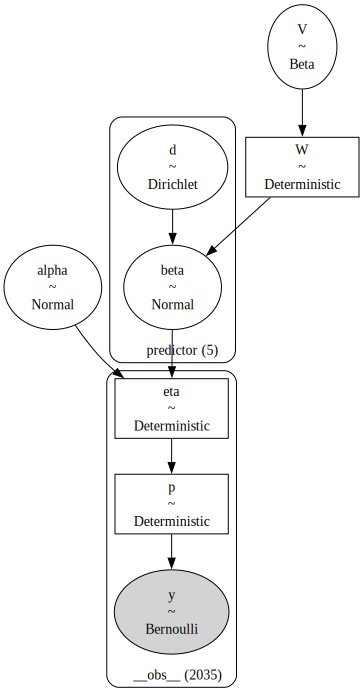

In [8]:
coords = {
    "predictor": ["age", "netuse", "treated", "green", "phc"],
    "__obs__": np.arange(X_std.shape[0])
}

with pm.Model(coords=coords) as model:
    V = pm.Beta("V", alpha=params[0], beta=params[1])
    W = pm.Deterministic("W", (V / (1 - V)) ** (1 / params[2]) * params[3])
    d = pm.Dirichlet("d", a=np.ones(5), dims="predictor")

    alpha = pm.Normal("alpha", mu=0, sigma=3 ** 0.5)
    beta = pm.Normal("beta", mu=0, sigma=(W * d) ** 0.5, dims="predictor")

    eta = pm.Deterministic("eta", alpha + X_std @ beta, dims="__obs__")
    p = pm.Deterministic("p", pm.math.sigmoid(eta), dims="__obs__")
    pm.Bernoulli("y", p=p, observed=y, dims="__obs__")

model.to_graphviz()

In [9]:
with model:
    idata = pm.sample(target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [V, d, alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


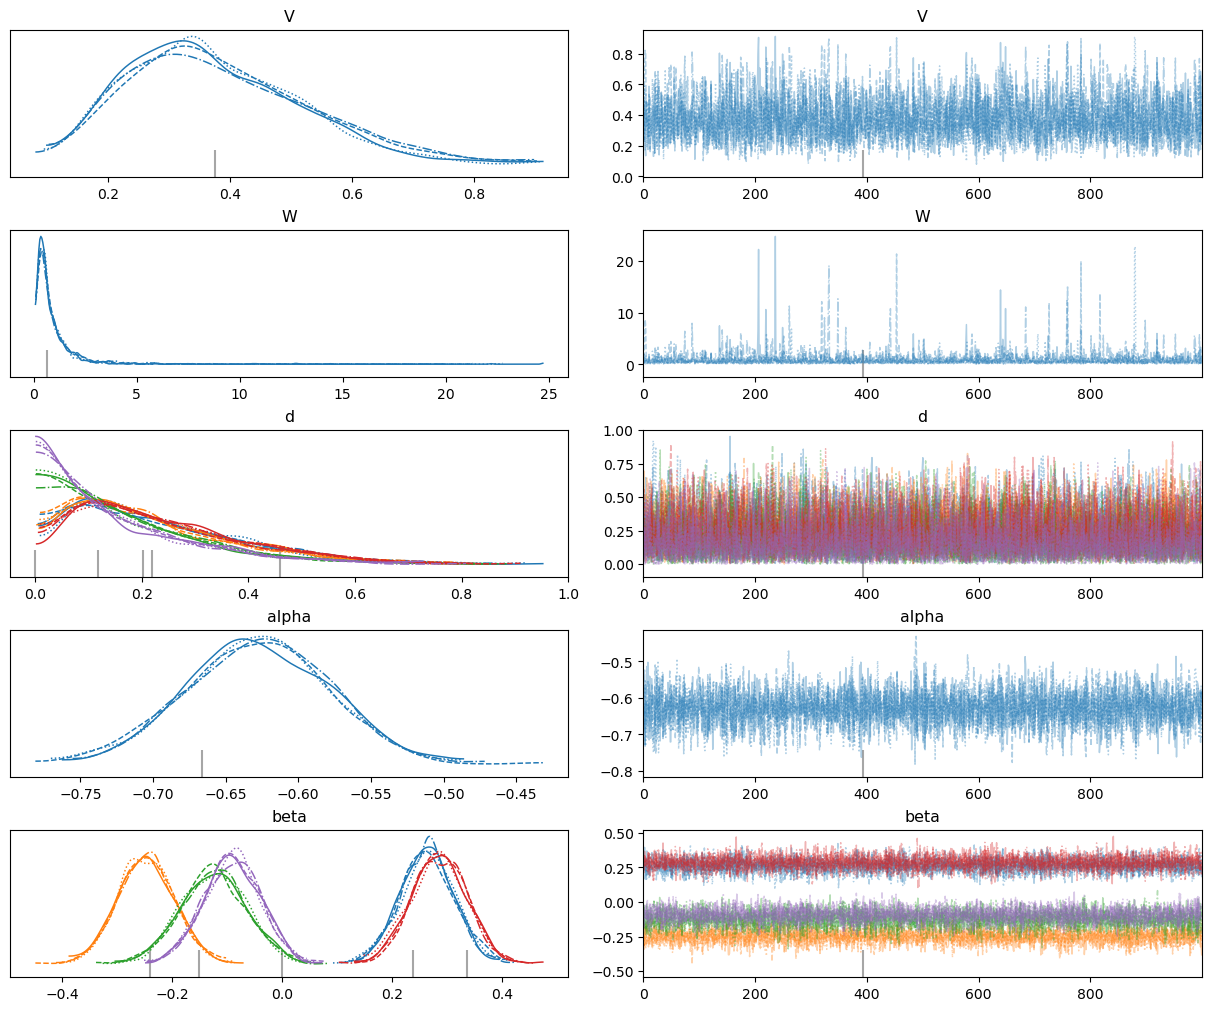

In [10]:
az.plot_trace(idata, var_names=["V", "W", "d", "alpha", "beta"], backend_kwargs={"layout": "constrained"});

----

$$
\begin{aligned}
Y_i \mid \pi_i &\sim \text{Bernoulli}(\pi_i) \\
\text{logit}(\pi_i) = \eta_i &= \beta_0 + {\bf X}_i\boldsymbol\beta+\alpha_{g[i]} \\
\beta_0 &\sim \text{Normal}(\mu_0, \tau_0^2) \\
\boldsymbol{\beta} &\sim \text{Normal}(0, \frac{1}{5} \phi_1 W \mathbf{I})  \\
\boldsymbol{\alpha} &\sim \text{Normal}(0, \phi_2 W \mathbf{C}) \\
\rho &\sim \text{Uniform}(0, 2r) \\
W &\sim \text{GBP}(a^*, b^*, c^*, d^*) \\
(\phi_1, \phi_2) &\sim \text{Dirichlet}(\xi_1, \xi_2)
\end{aligned}
$$

we assume

$$
\begin{aligned}
\mathbb{E}(\alpha_i) &= 0 \\
\mathbb{V}(\alpha_i) &= \sigma^2_\alpha & \text{for all } i \\
C_{ij} &= \text{Cor}(\alpha_i, \alpha_j) = e^{-d_{ij} / \rho} \\
\end{aligned}
$$

where $d_{ij}$ is the distance between village $i$ and $j$, and $\rho > 0$ is the spatial range parameter.

* $\mu_0 = 0$
* $\tau_0^2 = 3$
* $\xi_1 = \xi_2 = 1$
* $r$ is the maximum distance between pairs of villages.

In [11]:
df_locations = df.select("x", "y").unique(maintain_order=True).with_columns(location=pl.row_index())
df_locations

x,y,location
f64,i64,u32
349631.3,1458055,0
358543.1,1460112,1
360308.1,1460026,2
363795.7,1496919,3
366400.5,1460248,4
…,…,…
613529.5,1473868,60
614665.6,1482815,61
614722.5,1474320,62


In [12]:
df = df.join(df_locations, on=["x", "y"])
df

x,y,pos,age,netuse,treated,green,phc,location
f64,i64,i64,i64,i64,i64,f64,i64,u32
349631.3,1458055,1,1783,0,0,40.85,1,0
349631.3,1458055,0,404,1,0,40.85,1,0
349631.3,1458055,0,452,1,0,40.85,1,0
349631.3,1458055,1,566,1,0,40.85,1,0
349631.3,1458055,0,598,1,0,40.85,1,0
…,…,…,…,…,…,…,…,…
622086.1,1474011,1,1705,1,0,50.1,1,64
622086.1,1474011,1,1704,1,0,50.1,1,64
622086.1,1474011,1,1733,0,0,50.1,1,64


In [13]:
y = df.get_column("pos").to_numpy()
X = df.select("age", "netuse", "treated", "green", "phc").to_numpy()
X_std = (X - X.mean(0)) / X.std(0)

location_idx = df.get_column("location").to_numpy()

r = 0.986

In [14]:
def pl_scale(name):
    return (pl.col(name) - pl.col(name).mean()) / pl.col(name).std()


df_geo = (
    df.select("x", "y", "location").with_columns(x_std=pl_scale("x"), y_std=pl_scale("y"))
)
df_geo

x,y,location,x_std,y_std
f64,i64,u32,f64,f64
349631.3,1458055,0,-1.418594,-1.675692
349631.3,1458055,0,-1.418594,-1.675692
349631.3,1458055,0,-1.418594,-1.675692
349631.3,1458055,0,-1.418594,-1.675692
349631.3,1458055,0,-1.418594,-1.675692
…,…,…,…,…
622086.1,1474011,64,1.324388,-0.618882
622086.1,1474011,64,1.324388,-0.618882
622086.1,1474011,64,1.324388,-0.618882


In [15]:
X_geo_std = df_geo.select("x_std", "y_std").to_numpy()
X_geo_std

array([[-1.41859375, -1.6756917 ],
       [-1.41859375, -1.6756917 ],
       [-1.41859375, -1.6756917 ],
       ...,
       [ 1.32438789, -0.61888241],
       [ 1.32438789, -0.61888241],
       [ 1.32438789, -0.61888241]], shape=(2035, 2))

In [16]:
X_geo_std_unique = df_geo.select("x_std", "y_std").unique(maintain_order=True).to_numpy()
X_geo_std_unique


array([[-1.41859375, -1.6756917 ],
       [-1.3288728 , -1.53945099],
       [-1.31110339, -1.54514701],
       [-1.27599142,  0.89837675],
       [-1.24976719, -1.53044334],
       [-1.24687777, -1.34803843],
       [-1.22943052, -1.50918264],
       [-1.20950663, -1.52693301],
       [-1.20720919,  1.07521811],
       [-1.16920479,  1.1946357 ],
       [-1.14281041,  0.83711148],
       [-1.13078962, -1.58144254],
       [-1.12193512,  1.10396311],
       [-1.11534886, -1.56978558],
       [-1.09500716,  0.55111859],
       [-1.0903418 , -1.34704494],
       [-1.08101915,  1.16774522],
       [-1.04389466,  1.18615792],
       [-1.04100525, -1.37453152],
       [-1.01472262, -1.12920552],
       [-1.00812931, -1.31995576],
       [-0.99269861,  1.08819972],
       [-0.97847402,  0.94169295],
       [-0.95747188,  0.49694023],
       [-0.94093273,  1.2270235 ],
       [-0.03734335,  1.29954833],
       [-0.02247241,  1.66429192],
       [ 0.02788199,  1.80516892],
       [ 0.02816388,

In [17]:
n = len(y)
p = X_std.shape[1]
q = 1
L = len(np.unique(location_idx))

n, p, q, L

(2035, 5, 1, 65)

In [18]:
a = 1
b = 1

params = WGBP(a, b, b0=special.logit(np.mean(y)).item())
params

array([1.47281905, 0.64649438, 0.79884958, 1.26034246])

In [19]:
# Compute pairwise squared distances
diff = X_geo_std_unique[:, None, :] - X_geo_std_unique[None, :, :] # shape (L, L, 2)
dist = np.sqrt(np.sum(diff**2, axis=-1))   # shape (L, L)
dist

array([[0.        , 0.16312995, 0.1691038 , ..., 2.8780668 , 3.77929302,
        2.93952277],
       [0.16312995, 0.        , 0.01866003, ..., 2.74543973, 3.62034261,
        2.80842283],
       [0.1691038 , 0.01866003, 0.        , ..., 2.73072311, 3.61136768,
        2.79352472],
       ...,
       [2.8780668 , 2.74543973, 2.73072311, ..., 0.        , 1.54501226,
        0.07690731],
       [3.77929302, 3.62034261, 3.61136768, ..., 1.54501226, 0.        ,
        1.56468451],
       [2.93952277, 2.80842283, 2.79352472, ..., 0.07690731, 1.56468451,
        0.        ]], shape=(65, 65))

In [20]:
r = dist.max() # why does the case study say 0.986?

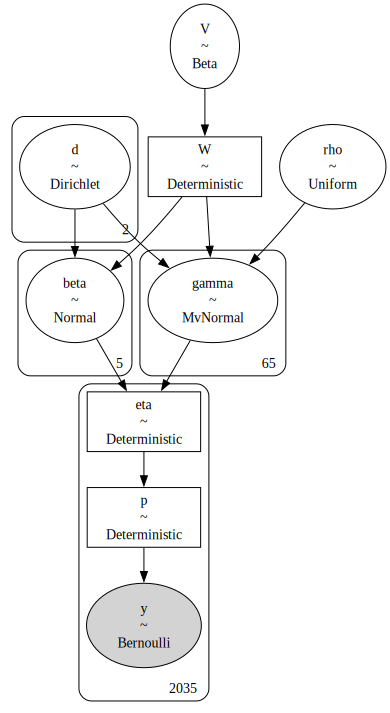

In [ ]:
with pm.Model() as model:
    # Correlation matrix
    rho = pm.Uniform("rho", lower=0, upper=2 * r)
    C = np.exp(-dist / rho) + np.eye(65)

    V = pm.Beta("V", alpha=params[0], beta=params[1])
    W = pm.Deterministic("W", (V / (1 - V)) ** (1 / params[2]) * params[3])
    d = pm.Dirichlet("d", a=np.ones(2))

    alpha = pm.Normal("alpha", mu=0, sigma=3 ** 0.5)
    beta = pm.Normal("beta", mu=0, sigma=(1 / p * W * d[0]) ** 0.5, shape=5)

    gamma = pm.MvNormal("gamma", mu=0, cov=d[1] * W * C)

    eta = pm.Deterministic("eta", alpha + X_std @ beta + gamma[location_idx])
    pi = pm.Deterministic("p", pm.math.sigmoid(eta))

    pm.Bernoulli("y", p=pi, observed=y)

model.to_graphviz()

In [29]:
with model:
    idata = pm.sample(target_accept=0.99, draws=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, V, d, beta, gamma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 161 seconds.


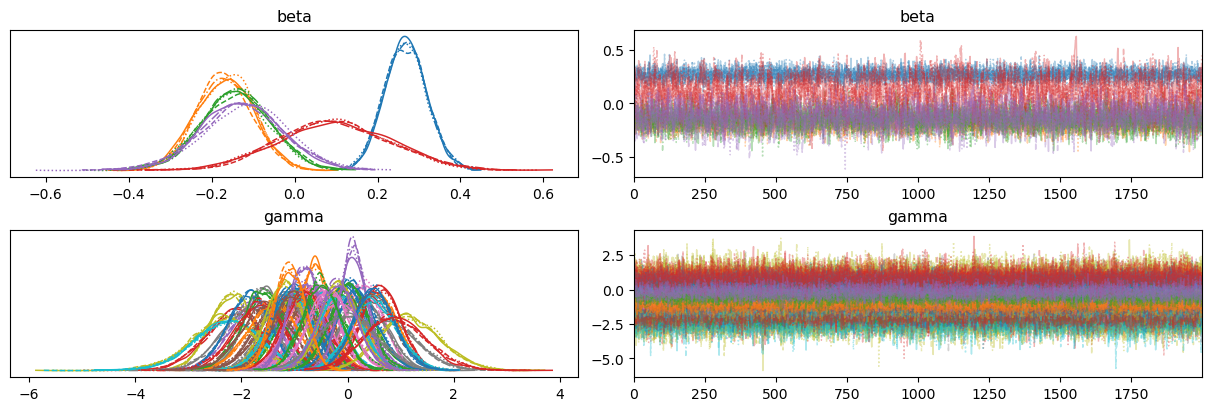

In [ ]:
az.plot_trace(idata, var_names=["alpha", "beta", "gamma"], backend_kwargs={"layout": "constrained"});

Correlation between alpha and gamma's... They're all intercepts

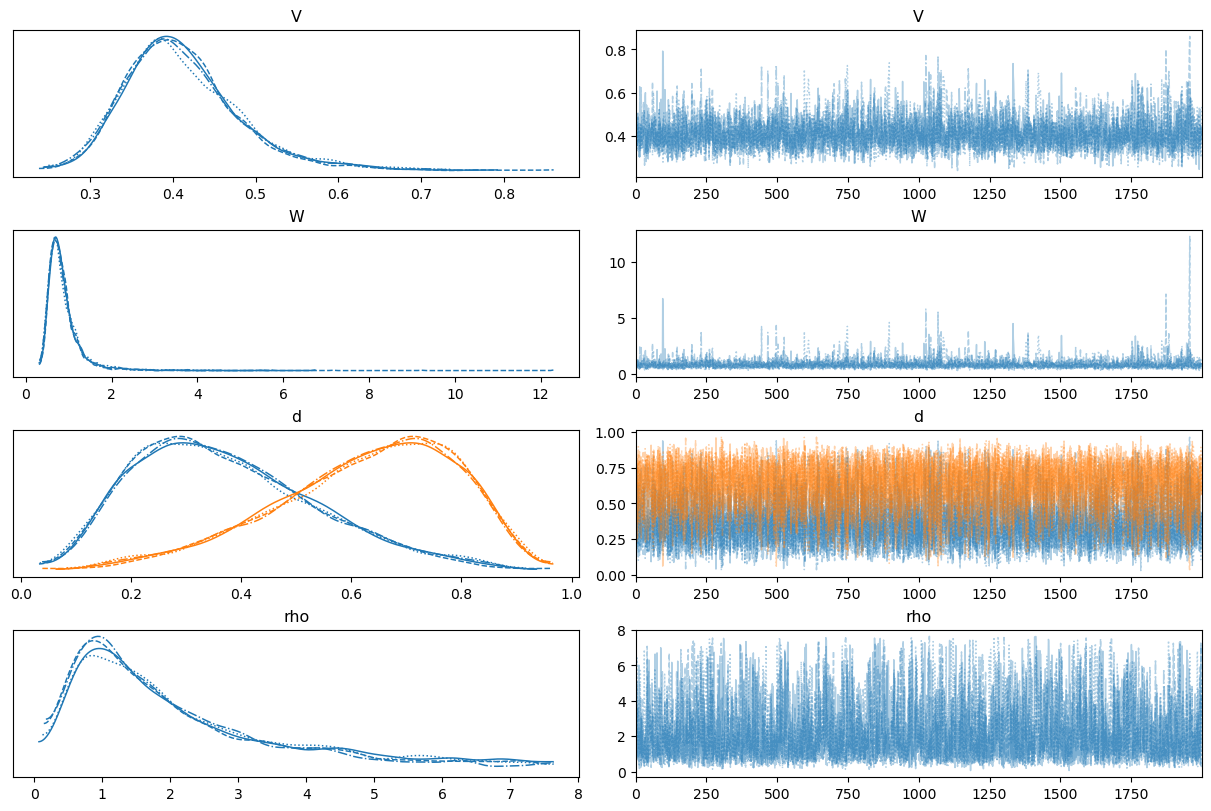

In [24]:
az.plot_trace(idata, var_names=["V", "W", "d", "rho"], backend_kwargs={"layout": "constrained"});